In [1]:
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [2]:
df = pd.read_csv('./data/fl_reg_name_race_2022.csv.gz')

In [3]:
df.head()

,name_last,name_first,race
0,Hessler-Smith,Jason,nh_white
1,Rogers,Renee,nh_white
2,Bartolome,Crystal,nh_white
3,Bailey,Donna,nh_white
4,Carlson,Greggory,nh_white


In [4]:
df.describe()

,name_last,name_first,race
count,15454992,15455022,15455110
unique,1341195,641103,8
top,Smith,Michael,nh_white
freq,79362,153753,9446851


In [5]:
df['race'].unique()

array(['nh_white', 'nh_black', 'other', 'hispanic', 'asian',
       'native_indian', 'unknown', 'multi_racial'], dtype=object)

## Drop none values

In [6]:
df.dropna(subset=['name_first', 'name_last'], inplace=True)

In [7]:
df.describe()

,name_last,name_first,race
count,15454908,15454908,15454908
unique,1341176,641095,8
top,Smith,Michael,nh_white
freq,79362,153753,9446749


## drop last name and first name of length 1

In [8]:
df = df.drop(df[df['name_last'].str.len() < 2].index)

In [9]:
df = df.drop(df[df['name_first'].str.len() < 2].index)

In [10]:
df.describe()

,name_last,name_first,race
count,15366690,15366690,15366690
unique,1340617,641055,8
top,Smith,Michael,nh_white
freq,79297,153752,9383680


## Remove special characters

In [11]:
df['full_name'] = df['name_last'] + ' ' + df['name_first']

In [12]:
df.head()

,name_last,name_first,race,full_name
0,Hessler-Smith,Jason,nh_white,Hessler-Smith Jason
1,Rogers,Renee,nh_white,Rogers Renee
2,Bartolome,Crystal,nh_white,Bartolome Crystal
3,Bailey,Donna,nh_white,Bailey Donna
4,Carlson,Greggory,nh_white,Carlson Greggory


In [13]:
df['full_name'] = df['full_name'].str.replace('[^a-zA-Z ]', '', regex=True)

In [14]:
df.head()

,name_last,name_first,race,full_name
0,Hessler-Smith,Jason,nh_white,HesslerSmith Jason
1,Rogers,Renee,nh_white,Rogers Renee
2,Bartolome,Crystal,nh_white,Bartolome Crystal
3,Bailey,Donna,nh_white,Bailey Donna
4,Carlson,Greggory,nh_white,Carlson Greggory


## drop duplicates

In [15]:
df[df[['full_name','race']].duplicated()]

,name_last,name_first,race,full_name
837,Moser,Patricia,nh_white,Moser Patricia
928,Johnson,Tiffany,nh_black,Johnson Tiffany
1247,Perry,Charles,nh_white,Perry Charles
2120,Johnson,Ashley,nh_black,Johnson Ashley
2285,Johnson,Clayton,nh_white,Johnson Clayton
...,...,...,...,...
15455101,Jones,Margaret,nh_white,Jones Margaret
15455102,Hartley,Brandon,nh_white,Hartley Brandon
15455104,Ballentine,Robert,nh_white,Ballentine Robert
15455106,Watts,Mark,nh_white,Watts Mark


In [16]:
df[df['full_name'] == "Porter Paula"]

,name_last,name_first,race,full_name
136,Porter,Paula,nh_white,Porter Paula
550,Porter,Paula,nh_black,Porter Paula
1527456,Porter,Paula,nh_white,Porter Paula
7563599,Porter,Paula,nh_white,Porter Paula
7631191,Porter,Paula,nh_white,Porter Paula
8383292,Porter,Paula,nh_white,Porter Paula
10682106,Porter,Paula,nh_white,Porter Paula


In [17]:
df = df.drop_duplicates(['full_name','race'],keep= 'last')

In [18]:
df[df['full_name'] == "Porter Paula"]

,name_last,name_first,race,full_name
550,Porter,Paula,nh_black,Porter Paula
10682106,Porter,Paula,nh_white,Porter Paula


In [19]:
df.shape

(10809021, 4)

## Extract features

In [20]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False)

In [21]:
X = vectorizer.fit_transform(df['full_name'])

In [22]:
X[:10].toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [23]:
vectorizer.get_feature_names_out()

array([' ', ' A', ' B', ..., 'zx', 'zy', 'zz'], dtype=object)

In [24]:
len(vectorizer.get_feature_names_out())

2767

In [25]:
vocab = vectorizer.get_feature_names_out()

In [26]:
set(df.race.factorize()[0])

{0, 1, 2, 3, 4, 5, 6, 7}

In [27]:
df['race_code'] = df.race.factorize()[0]

In [28]:
df.head()

,name_last,name_first,race,full_name,race_code
0,Hessler-Smith,Jason,nh_white,HesslerSmith Jason,0
2,Bartolome,Crystal,nh_white,Bartolome Crystal,0
4,Carlson,Greggory,nh_white,Carlson Greggory,0
5,McDowell,Terrica,nh_black,McDowell Terrica,1
6,Luong,Lin,other,Luong Lin,2


In [29]:
df[['race', 'race_code']].drop_duplicates().sort_values('race_code')

,race,race_code
0,nh_white,0
5,nh_black,1
6,other,2
22,hispanic,3
32,asian,4
66,native_indian,5
158,multi_racial,6
610,unknown,7


In [30]:
race_id_df = df[['race', 'race_code']].drop_duplicates().sort_values('race_code')
race_to_id = dict(race_id_df.values)

In [31]:
race_to_id

{'nh_white': 0,
 'nh_black': 1,
 'other': 2,
 'hispanic': 3,
 'asian': 4,
 'native_indian': 5,
 'multi_racial': 6,
 'unknown': 7}

In [32]:
id_to_race = dict(race_id_df[['race_code', 'race']].values)

In [33]:
id_to_race

{0: 'nh_white',
 1: 'nh_black',
 2: 'other',
 3: 'hispanic',
 4: 'asian',
 5: 'native_indian',
 6: 'multi_racial',
 7: 'unknown'}

In [34]:
y = df.race_code

In [35]:
y[0]

0

In [36]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
#Create a Gaussian Classifier
clf = RandomForestClassifier(criterion = 'entropy', random_state=42, verbose=6, n_jobs=-1)

In [38]:
print(X_train.shape)
print(X_test.shape)

(8647216, 2767)
(2161805, 2767)


## Training

## Doing it for 1 million with 100 trees

In [53]:
%%time
#Train the model using the training sets y_pred=clf.predict(X_test)

# 1 million
samples = 100 * 100 * 100
# 1 million records took 2h 10min 13s
# 8 million records will take ~17 hours

clf.fit(X_train[:samples], y_train[:samples])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 18.7min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed: 57.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 58.7min finished


CPU times: user 9h 17min 3s, sys: 3min 36s, total: 9h 20min 39s
Wall time: 58min 59s


RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42,
                       verbose=6)

In [54]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   48.6s
[Parallel(n_jobs=10)]: Done  98 out of 100 | elapsed:  2.0min remaining:    2.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  2.1min finished


Accuracy: 0.6849614095628421
CPU times: user 12min 10s, sys: 56.3 s, total: 13min 7s
Wall time: 2min 25s


In [55]:
joblib.dump(vectorizer, "fl_voter_name_rf_vect_1M.joblib", compress=3)  # compression is ON!

['fl_voter_name_rf_vect_1M.joblib']

In [56]:
joblib.dump(clf, "fl_voter_name_rf_model_1M.joblib", compress=3)  # compression is ON!

['fl_voter_name_rf_model_1M.joblib']

## Doing it for 2 million with 100 trees

In [44]:
%%time
#Train the model using the training sets y_pred=clf.predict(X_test)

# 2 million
samples = 2 * 100 * 100 * 100
# 1 million records took 2h 10min 13s
# 2 million records took 3h 50 mins
# 8 million records will take ~17 hours

clf.fit(X_train[:samples], y_train[:samples])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 72.3min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 82 of 100building tree 81 

[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed: 230.2min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 230.4min finished


CPU times: user 1d 12h 57min 45s, sys: 25min 54s, total: 1d 13h 23min 40s
Wall time: 3h 50min 37s


RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42,
                       verbose=6)

In [ ]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   36.0s
[Parallel(n_jobs=10)]: Done  98 out of 100 | elapsed:  1.7min remaining:    2.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.7min finished


Accuracy: 0.688610674875856
CPU times: user 14min 1s, sys: 54.8 s, total: 14min 56s
Wall time: 2min 4s


# Now lets do for the whole train set with 20 trees

In [46]:
%%time

clf = RandomForestClassifier(n_estimators=20, criterion = 'entropy', random_state=42, verbose=6, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed: 552.8min remaining: 1658.5min


building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed: 555.8min remaining: 679.3min


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed: 1107.0min remaining: 596.1min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed: 1115.0min remaining: 196.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 1124.4min finished


CPU times: user 7d 15h 7min 5s, sys: 15min 31s, total: 7d 15h 22min 37s
Wall time: 18h 45min 58s


RandomForestClassifier(criterion='entropy', n_estimators=20, n_jobs=-1,
                       random_state=42, verbose=6)

In [ ]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:  2.1min remaining:  6.2min
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:  2.1min remaining:  2.5min
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:  3.0min remaining:  1.6min
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:  3.0min remaining:   31.9s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  3.1min finished


Accuracy: 0.6730477540758764
CPU times: user 25min 56s, sys: 54.8 s, total: 26min 51s
Wall time: 3min 57s


In [ ]:
joblib.dump(vectorizer, "fl_voter_name_rf_vect.joblib", compress=3)  # compression is ON!

['fl_voter_name_rf_vect.joblib']

In [ ]:
joblib.dump(clf, "fl_voter_name_rf_model.joblib", compress=3)  # compression is ON!

['fl_voter_name_rf_model.joblib']

In [ ]:
!~/pushover "ethnicolor job is done" 1 whistle

{"status":1,"request":"0df17586-ffec-4be6-aae4-30cf2cd24fba"}

## Confustion Matrix

## For 1M Model

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   27.6s
[Parallel(n_jobs=10)]: Done  98 out of 100 | elapsed:   51.5s remaining:    1.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   51.7s finished


               precision    recall  f1-score   support

        asian       0.63      0.11      0.19     57636
     hispanic       0.75      0.62      0.68    357839
 multi_racial       0.01      0.00      0.00     16776
native_indian       0.00      0.00      0.00      9397
     nh_black       0.64      0.15      0.24    318456
     nh_white       0.68      0.95      0.79   1263354
        other       0.04      0.00      0.00     55480
      unknown       0.02      0.00      0.00     82867

     accuracy                           0.68   2161805
    macro avg       0.35      0.23      0.24   2161805
 weighted avg       0.63      0.68      0.62   2161805



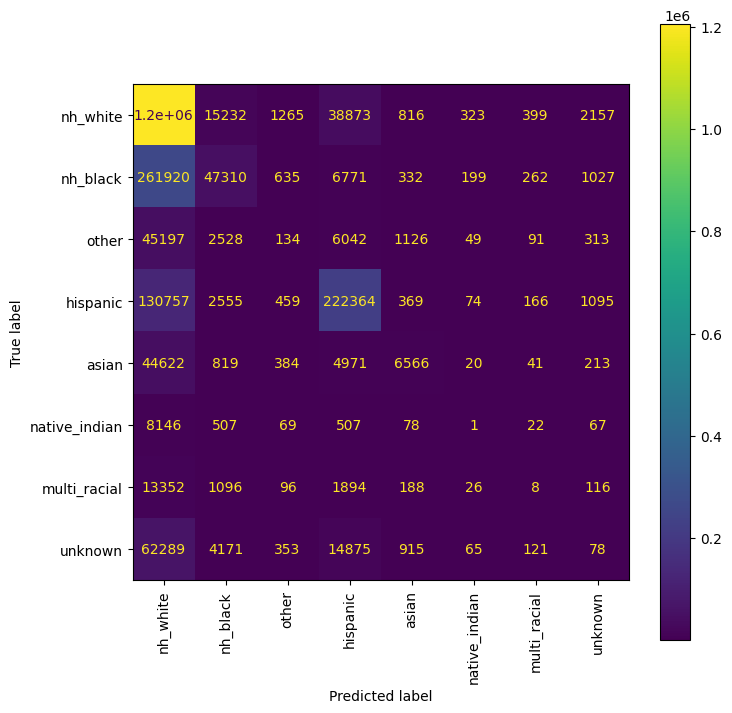

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline  

model_1m = joblib.load('fl_voter_name_rf_model_1M.joblib')
preds = model_1m.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

## For Model trained with complete dataset (20 trees)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:   10.8s remaining:   32.5s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:   13.0s remaining:   15.9s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:   18.8s remaining:   10.1s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:   20.0s remaining:    3.5s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:   34.0s finished


               precision    recall  f1-score   support

        asian       0.51      0.19      0.28     57636
     hispanic       0.71      0.64      0.67    357839
 multi_racial       0.00      0.00      0.00     16776
native_indian       0.00      0.00      0.00      9397
     nh_black       0.51      0.27      0.35    318456
     nh_white       0.70      0.89      0.79   1263354
        other       0.04      0.01      0.02     55480
      unknown       0.00      0.00      0.00     82867

     accuracy                           0.67   2161805
    macro avg       0.31      0.25      0.26   2161805
 weighted avg       0.62      0.67      0.63   2161805



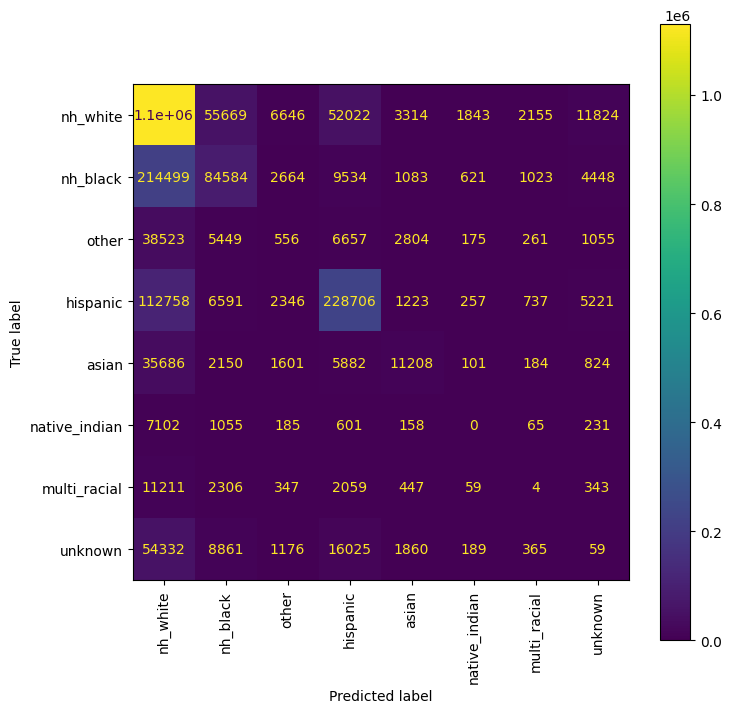

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline  

model_1m = joblib.load('fl_voter_name_rf_model.joblib')
preds = model_1m.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')